In [131]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii

In [132]:
table = ascii.read('data/stats_table.csv', format='csv', delimiter=',')
table.add_index('kepid')

If the mean flux before transit is significantly different from the mean flux after transit, mask those results. 

In [133]:
[n for n in table.colnames if n.startswith('ks')]

['ks:in_transit-vs-out_of_transit',
 'ks:out_of_transit&before_midtransit-vs-out_of_transit&after_midtransit',
 'ks:in_transit&before_midtransit-vs-in_transit&after_midtransit']

/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:867: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


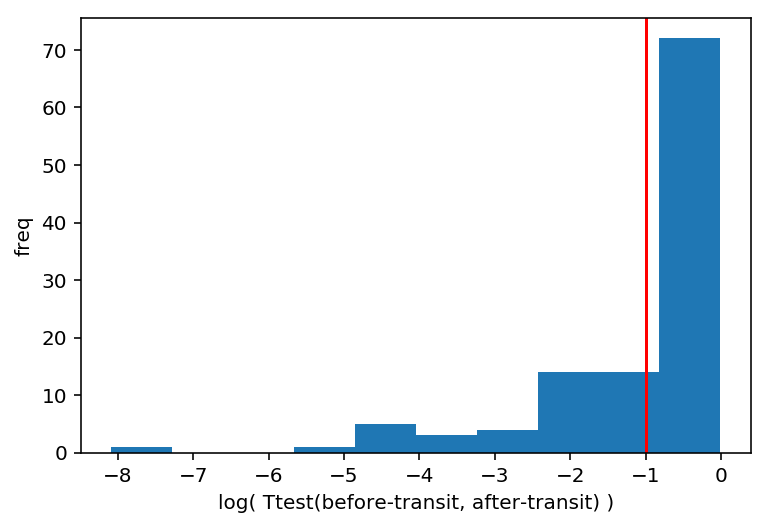

In [134]:
p = table['ttest:out_of_transit&before_midtransit-vs-out_of_transit&after_midtransit']

poorly_normalized_oot_threshold = -1 

mask_poorly_normalized_oot = np.log(p) > poorly_normalized_oot_threshold

plt.hist(np.log(p[~np.isnan(p)]))
plt.axvline(poorly_normalized_oot_threshold, color='r')
plt.ylabel('freq')
plt.xlabel('log( Ttest(before-transit, after-transit) )')
plt.show()

If the distribution of fluxs before transit is significantly different from the distribution of fluxs after transit, mask those results. 

/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:867: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


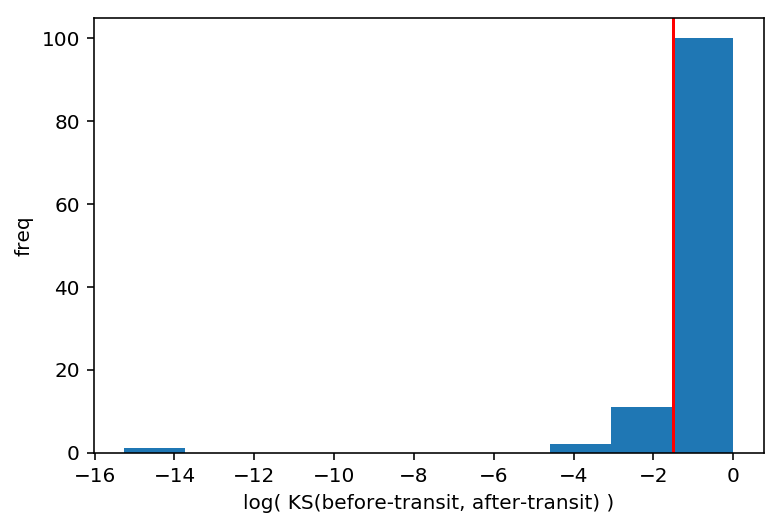

In [135]:
p = table['ks:out_of_transit&before_midtransit-vs-out_of_transit&after_midtransit']

mask_different_rms_before_vs_after_thresh = -1.5
mask_different_rms_before_vs_after = np.log(p) > mask_different_rms_before_vs_after_thresh

plt.hist(np.log(p[~np.isnan(p)]))
plt.axvline(mask_different_rms_before_vs_after_thresh, color='r')
plt.ylabel('freq')
plt.xlabel('log( KS(before-transit, after-transit) )')
plt.show()

In [136]:
combined_mask = mask_poorly_normalized_oot | mask_different_rms_before_vs_after

print("stars left after cuts:", np.count_nonzero(table['kepid'][combined_mask]))

stars left after cuts: 104


/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


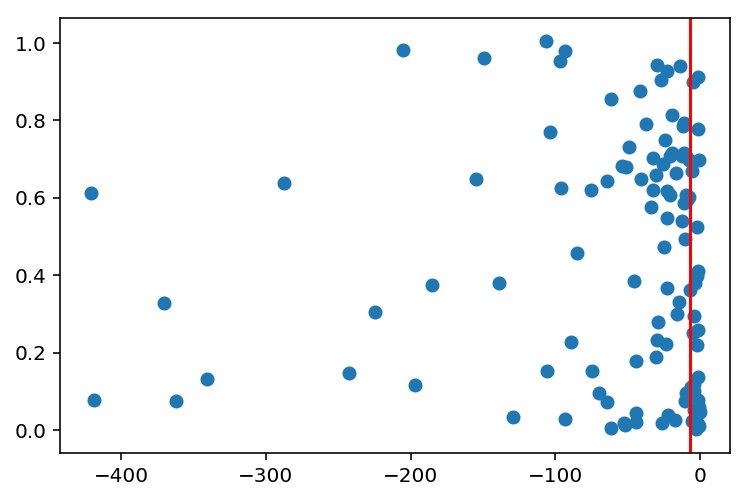

In [46]:
ks_in_out = table['ks:in_transit-vs-out_of_transit']
b = table['B']

thresh = 0.001
mask_notable_intransit = ks_in_out < thresh

plt.scatter(np.log(ks_in_out), b)
plt.axvline(np.log(thresh), color='r')

 kepid 
-------
5031857
5564082
6946199
7499398


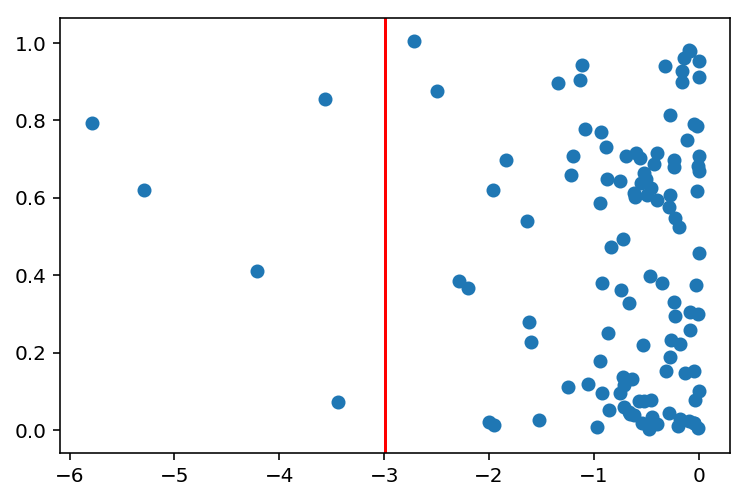

In [51]:
ks_in_in = table['ks:in_transit&before_midtransit-vs-in_transit&after_midtransit']
anderson_in_in = table['anderson:in_transit&before_midtransit-vs-in_transit&after_midtransit']

b = table['B']

thresh = 0.05
mask_asymmetric_in = (ks_in_in < thresh) & (anderson_in_in < thresh)

print(table['kepid'][mask_asymmetric_in])

plt.scatter(np.log(ks_in_in), rb)
plt.axvline(np.log(thresh), color='r')

In [138]:
large_planets = table['R'].data > 0.1
close_in_planets = table['PER'] < 10

close_in_large_planets = (large_planets & close_in_planets) & combined_mask
far_out_small_planets = np.logical_not(close_in_large_planets) & combined_mask

In [139]:
np.count_nonzero(close_in_large_planets.data), np.count_nonzero(far_out_small_planets)

(49, 55)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


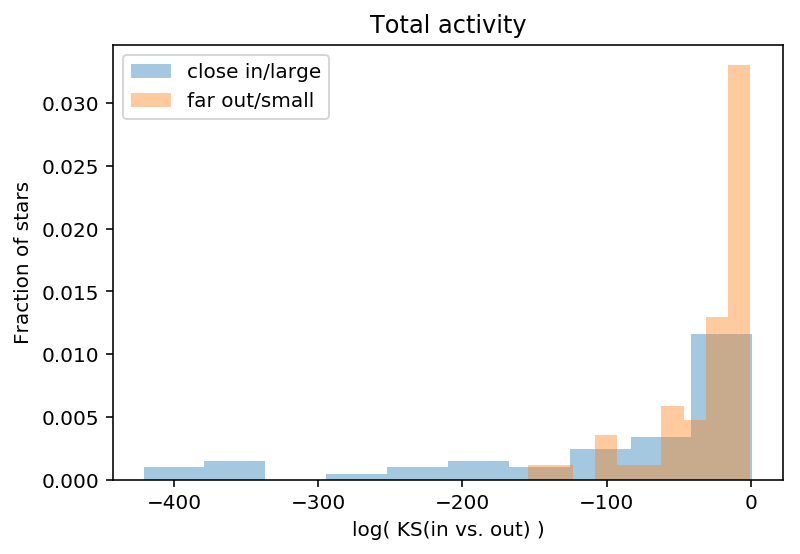

In [140]:
plt.hist(np.log(table['ks:in_transit-vs-out_of_transit'])[close_in_large_planets], 
         label='close in/large', alpha=0.4, normed=True)
plt.hist(np.log(table['ks:in_transit-vs-out_of_transit'])[far_out_small_planets],
         label='far out/small', alpha=0.4, normed=True)
plt.legend()
plt.xlabel('log( KS(in vs. out) )')
plt.ylabel('Fraction of stars')
plt.title("Total activity")
plt.show()

It seems that close-in, large exoplanets orbit more active stars (with larger in-transit RMS) than far out/small planets

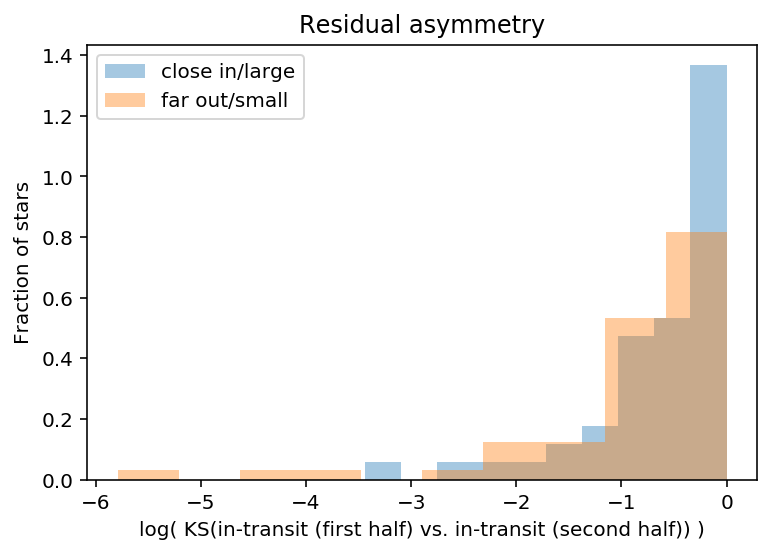

In [141]:
plt.hist(np.log(table['ks:in_transit&before_midtransit-vs-in_transit&after_midtransit'])[close_in_large_planets], 
         label='close in/large', alpha=0.4, normed=True)
plt.hist(np.log(table['ks:in_transit&before_midtransit-vs-in_transit&after_midtransit'])[far_out_small_planets],
         label='far out/small', alpha=0.4, normed=True)
plt.legend()
plt.xlabel('log( KS(in-transit (first half) vs. in-transit (second half)) )')
plt.ylabel('Fraction of stars')
plt.title("Residual asymmetry")
plt.show()

Transit residuals are more asymmetric for far-out, small exoplanets. 

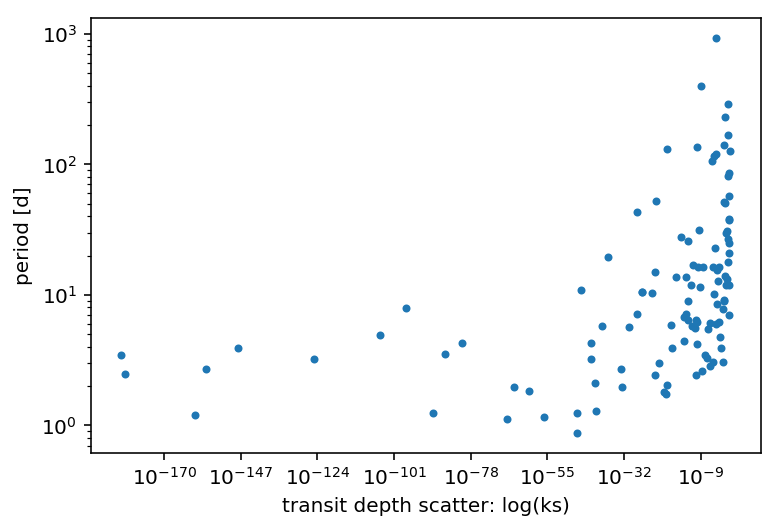

In [142]:
plt.loglog(table['ks:in_transit-vs-out_of_transit'], 
           table['PER'], '.')
plt.xlabel('transit depth scatter: log(ks)')
plt.ylabel('period [d]')

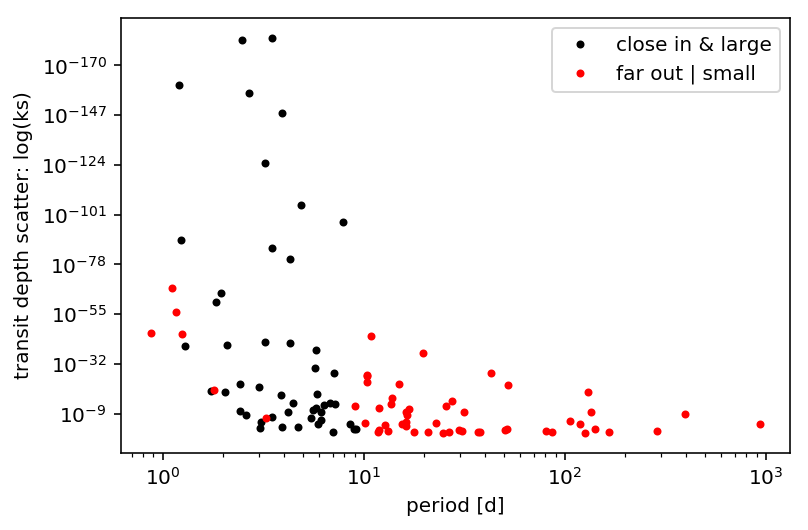

In [190]:
plt.loglog(table['PER'][close_in_large_planets], 
           table['ks:in_transit-vs-out_of_transit'][close_in_large_planets], 'k.', label='close in & large')
plt.loglog(table['PER'][far_out_small_planets], 
           table['ks:in_transit-vs-out_of_transit'][far_out_small_planets], 'r.', label='far out | small')
plt.legend()
plt.ylabel('transit depth scatter: log(ks)')
plt.xlabel('period [d]')
ax = plt.gca()
ax.invert_yaxis()

Stars with short period planets have disproportionately larger scatter in transit

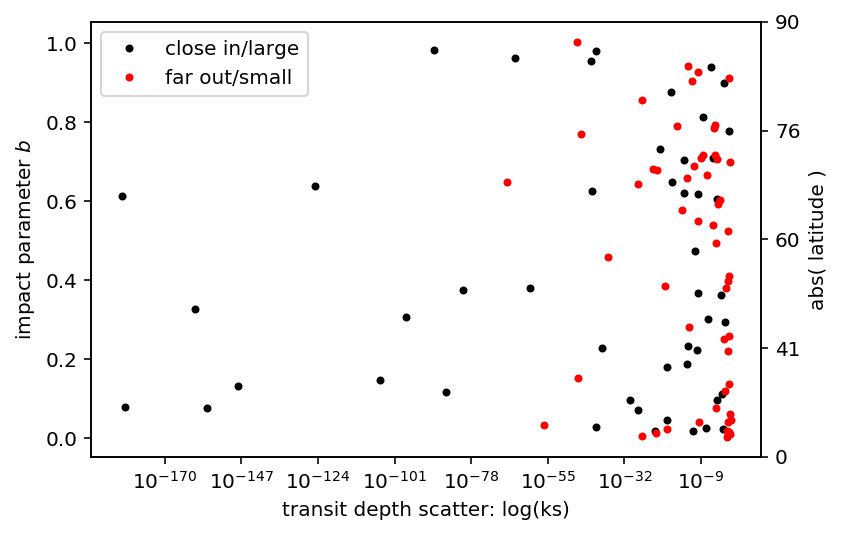

In [191]:
plt.semilogx(table['ks:in_transit-vs-out_of_transit'][close_in_large_planets], 
             table['B'][close_in_large_planets], 'k.', label='close in/large')
plt.semilogx(table['ks:in_transit-vs-out_of_transit'][far_out_small_planets], 
             table['B'][far_out_small_planets], 'r.', label='far out/small')
plt.legend()
ax = plt.gca()
ax.set_xlabel('transit depth scatter: log(ks)')
ax.set_ylabel('impact parameter $b$')

ax2 = ax.twinx()
y2 = 1 - np.linspace(0, 1, 5)
y2labels = np.degrees(np.arccos(y2))[::-1]
ax2.set_yticks(y2)
ax2.set_yticklabels([int(round(i)) for i in y2labels])
#ax2.set_ylim([0, 90])
ax2.set_ylabel('abs( latitude )')

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in arccos
  from ipykernel import kernelapp as app


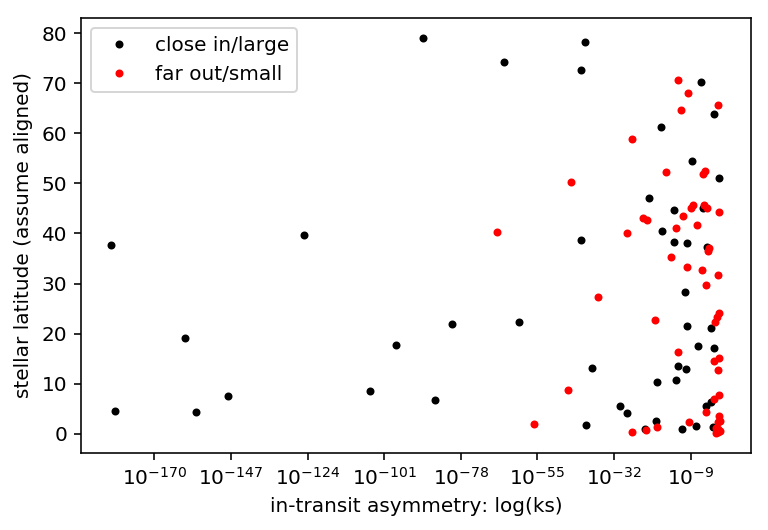

In [192]:
def b_to_latitude_deg(b):
    return 90 - np.degrees(np.arccos(b))

abs_latitude = b_to_latitude_deg(table['B'])

plt.semilogx(table['ks:in_transit-vs-out_of_transit'][close_in_large_planets], 
             abs_latitude[close_in_large_planets], 'k.', label='close in/large')
plt.semilogx(table['ks:in_transit-vs-out_of_transit'][far_out_small_planets], 
             abs_latitude[far_out_small_planets], 'r.', label='far out/small')
plt.legend()
ax = plt.gca()
ax.set_xlabel('in-transit asymmetry: log(ks)')
ax.set_ylabel('stellar latitude (assume aligned)')

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log


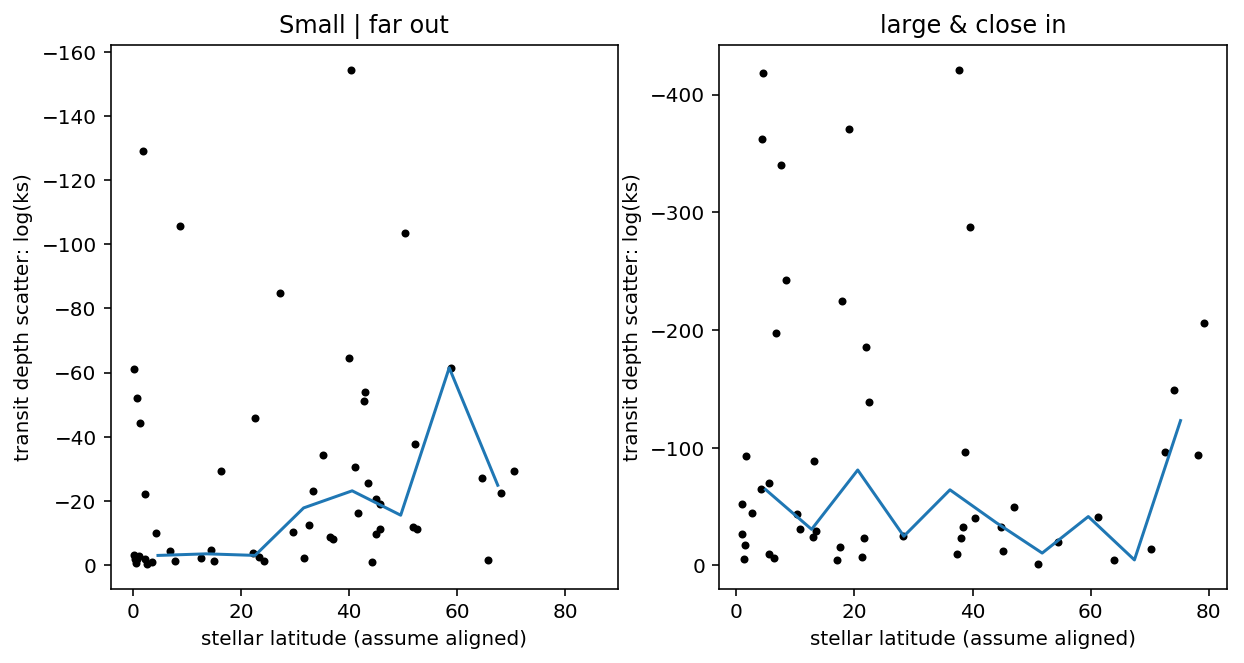

In [193]:
from scipy.stats import binned_statistic

bs = binned_statistic(abs_latitude[far_out_small_planets], 
                      np.log(table['ks:in_transit-vs-out_of_transit'][far_out_small_planets]),
                      statistic='median', bins=10)
bincenter = 0.5 * (bs.bin_edges[:-1] + bs.bin_edges[1:])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(abs_latitude[far_out_small_planets], 
         np.log(table['ks:in_transit-vs-out_of_transit'][far_out_small_planets]),
         'k.', label='far out/small')

ax[0].plot(bincenter, bs.statistic, label='median')

ax[0].invert_yaxis()
ax[0].set_ylabel('transit depth scatter: log(ks)')
ax[0].set_xlabel('stellar latitude (assume aligned)')


bs = binned_statistic(abs_latitude[close_in_large_planets], 
                      np.log(table['ks:in_transit-vs-out_of_transit'][close_in_large_planets]),
                      statistic='median', bins=10)
bincenter = 0.5 * (bs.bin_edges[:-1] + bs.bin_edges[1:])

ax[1].plot(abs_latitude[close_in_large_planets], 
           np.log(table['ks:in_transit-vs-out_of_transit'][close_in_large_planets]),
           'k.', label='far out/small')

ax[1].plot(bincenter, bs.statistic, label='median')

ax[1].invert_yaxis()
ax[1].set_ylabel('transit depth scatter: log(ks)')
ax[1].set_xlabel('stellar latitude (assume aligned)')

ax[0].set_title('Small | far out')
ax[1].set_title('large & close in')

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log


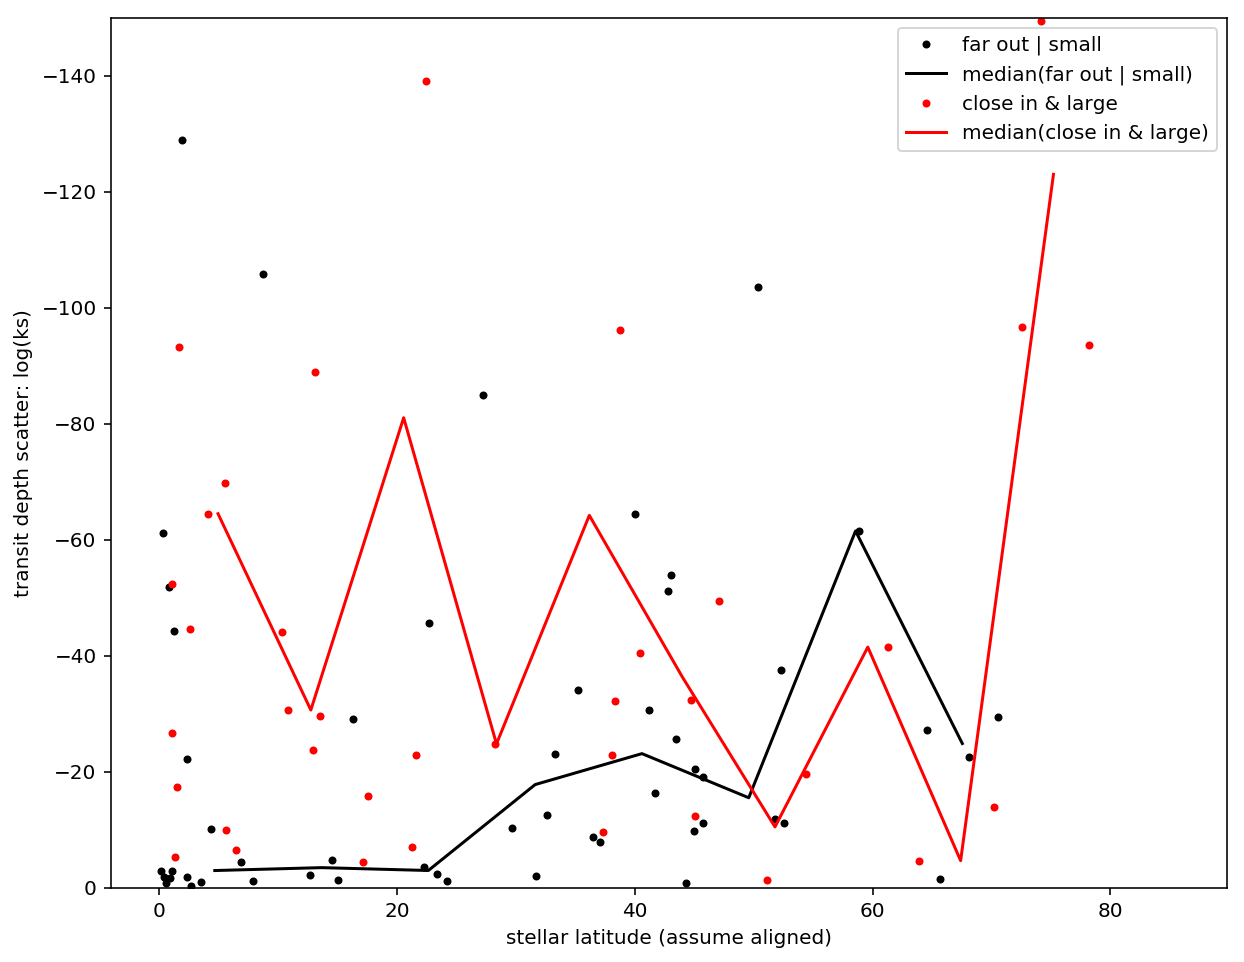

In [194]:
from scipy.stats import binned_statistic

bs = binned_statistic(abs_latitude[far_out_small_planets], 
                      np.log(table['ks:in_transit-vs-out_of_transit'][far_out_small_planets]),
                      statistic='median', bins=10)
bincenter = 0.5 * (bs.bin_edges[:-1] + bs.bin_edges[1:])

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.plot(abs_latitude[far_out_small_planets], 
         np.log(table['ks:in_transit-vs-out_of_transit'][far_out_small_planets]),
         'k.', label='far out | small')

ax.plot(bincenter, bs.statistic, 'k', label='median(far out | small)')

ax.set_ylabel('transit depth scatter: log(ks)')
ax.set_xlabel('stellar latitude (assume aligned)')


bs = binned_statistic(abs_latitude[close_in_large_planets], 
                      np.log(table['ks:in_transit-vs-out_of_transit'][close_in_large_planets]),
                      statistic='median', bins=10)
bincenter = 0.5 * (bs.bin_edges[:-1] + bs.bin_edges[1:])

ax.plot(abs_latitude[close_in_large_planets], 
           np.log(table['ks:in_transit-vs-out_of_transit'][close_in_large_planets]),
           'r.', label='close in & large')

ax.plot(bincenter, bs.statistic, 'r', label='median(close in & large)')

# ax.set_ylabel('transit depth scatter: log(ks)')
# ax.set_xlabel('stellar latitude (assume aligned)')
ax.legend()
ax.invert_yaxis()

ax.set_ylim([0, -150])
plt.show()
#ax.set_title('Small | far out')
#ax.set_title('large & close in')

In the above plot, the vertical axis is the significance of the scatter in-transit vs. out-of-transit (upward = more significant scatter).

A transiting planet with a higher $b$ (high latitudes) will occult a larger fraction of the stellar surface (per instant) than transiting planets at lower $b$ (low latitudes). Does that mean that we should expect more scatter at higher latitudes?